In [1]:
# !pip install pyspark

In [1]:
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

In [2]:
def symmetric_mean_absolute_percentage_error(A, F):
    with np.errstate(divide='ignore', invalid='ignore'):
        tmp = 2 * np.abs(F-A) / (np.abs(A) + np.abs(F))
    tmp[np.isnan(tmp)] = 0
    return np.sum(tmp) / len(tmp) * 100

In [3]:
spark = SparkSession \
    .builder \
    .appName("Time series data analysis with Spark") \
    .getOrCreate()

## Data processing

In [4]:
weather_df = spark.read.csv("../../weather_download/merged_historic_Hamburg.csv", inferSchema="true", header="true")
website_df = spark.read.csv("../../ggtrends_downloads/Instagram_Hamburg_historic.csv", inferSchema="true", header="true")

weather_df = weather_df.withColumnRenamed("Date time", "date")
weather_df = weather_df.withColumn("date", to_timestamp(col("date"),"MM/dd/yyyy HH:mm:ss").alias("date"))

website_df = website_df.select(to_timestamp(col("date"),"MM-dd-yyyy").alias("date"), col("value").alias("y"))


columns = [
    "date",
    "Address",
    "Temperature",
    "Relative Humidity",
    "Wind Speed",
    "Visibility",
    "Cloud Cover",
    "y"]



df = weather_df.join(website_df, how="inner", on="date").select(*columns)
partition = Window.partitionBy("Address").orderBy(col("date").asc())
df = df.withColumn("lag1", lag("y", 1).over(partition))
df = df.withColumn("lag24", lag("y", 24).over(partition)).drop("Address").na.drop(subset=["lag1", "lag24"]).na.fill(0)

columns = [
    "date",
    "Temperature",
    "Relative Humidity",
    "Wind Speed",
    "Visibility",
    "lag1",
    "lag24",
    "y"]

In [5]:
# detrending using diff
diff_ranks = {}
for _col in columns[1:]:
    k=0
    series = df.select("date", _col).toPandas().set_index("date").dropna()
    test_pval = adfuller(series)[1]
    while test_pval > 0.05:
        k += 1
        series = series.diff(periods=1)
        series.dropna(inplace=True)
        test_pval = adfuller(series)[1]
    diff_ranks[_col] = k
    
diff_ranks

# all series are stationary

{'Temperature': 0,
 'Relative Humidity': 0,
 'Wind Speed': 0,
 'Visibility': 0,
 'lag1': 0,
 'lag24': 0,
 'y': 0}

In [6]:
_df = df.withColumn("filter_col", when(date_format(col("date"),"HH:mm:ss").between("07:00:00","23:00:00"),"day").otherwise("night"))

## Models training

In [7]:
# Days
df_day = _df.filter(col("filter_col")=="day").drop("filter_col")

# train test split
df_day = df_day.withColumn("rank", percent_rank().over(Window.partitionBy().orderBy("date")))
df_day_train = df_day.where("rank <= .8").select(*columns).sort('date')
df_day_test = df_day.where("rank > .8").select(*columns).sort('date')

# Chain model, assembler and scaler into a Pipeline.
assembler = VectorAssembler(inputCols=columns[1:-1], outputCol='features')
scaler = MinMaxScaler(inputCol='features', outputCol='scaled_features')
lr = LinearRegression(featuresCol="scaled_features",  labelCol=columns[-1], regParam=0.3, elasticNetParam=0.8)
pipeline = Pipeline(stages=[assembler, scaler, lr])

# Train model on training data. 
lr_model = pipeline.fit(df_day_train)

# Predict
pred_day_train = lr_model.transform(df_day_train)
_columns = columns+["prediction", "features", "scaled_features"]
pred_day_train = pred_day_train.select(*_columns).sort('date')

pred_day_test = lr_model.transform(df_day_test)
_columns = columns+["prediction", "features", "scaled_features"]
pred_day_test = pred_day_test.select(*_columns).sort('date')

In [8]:
# Nights
df_night = _df.filter(col("filter_col")=="night").drop("filter_col")

# train test split
df_night = df_night.withColumn("rank", percent_rank().over(Window.partitionBy().orderBy("date")))
df_night_train = df_night.where("rank <= .8").select(*columns).sort('date')
df_night_test = df_night.where("rank > .8").select(*columns).sort('date')

# Chain model, assembler and scaler into a Pipeline.
assembler = VectorAssembler(inputCols=columns[1:-1], outputCol='features')
scaler = MinMaxScaler(inputCol='features', outputCol='scaled_features')
lr = LinearRegression(featuresCol="scaled_features",  labelCol=columns[-1], regParam=0.3, elasticNetParam=0.8)
pipeline = Pipeline(stages=[assembler, scaler, lr])

# Train model on training data. 
lr_model = pipeline.fit(df_night_train)

# Predict
pred_night_train = lr_model.transform(df_night_train)
_columns = columns+["prediction", "features", "scaled_features"]
pred_night_train = pred_night_train.select(*_columns).sort('date')

pred_night_test = lr_model.transform(df_night_test)
_columns = columns+["prediction", "features", "scaled_features"]
pred_night_test = pred_night_test.select(*_columns).sort('date')

In [9]:
pred_train = pred_day_train.union(pred_night_train).select("date", "y", "prediction").sort('date')
pred_test = pred_day_test.union(pred_night_test).select("date", "y", "prediction").sort('date')

## Error analysis

In [10]:
# error on train
symmetric_mean_absolute_percentage_error(
    A=np.array(pred_train.toPandas().y),
    F=np.array(pred_train.toPandas().prediction))

152.85039125064105

In [11]:
# error on train for days only
symmetric_mean_absolute_percentage_error(
    A=np.array(pred_day_train.toPandas().y),
    F=np.array(pred_day_train.toPandas().prediction))

145.99992849920295

In [12]:
# error on train for nights only
symmetric_mean_absolute_percentage_error(
    A=np.array(pred_night_train.toPandas().y),
    F=np.array(pred_night_train.toPandas().prediction))

169.36290197018596

In [13]:
# error on test
symmetric_mean_absolute_percentage_error(
    A=np.array(pred_test.toPandas().y),
    F=np.array(pred_test.toPandas().prediction))

151.04524037898278

In [14]:
# error on test for days only
symmetric_mean_absolute_percentage_error(
    A=np.array(pred_day_test.toPandas().y),
    F=np.array(pred_day_test.toPandas().prediction))

143.47903048873187

In [15]:
# error on test for nights only
symmetric_mean_absolute_percentage_error(
    A=np.array(pred_night_test.toPandas().y),
    F=np.array(pred_night_test.toPandas().prediction))

169.2811871749862

In [16]:
# model is not overfitted

In [17]:
pred = pred_train.union(pred_test).sort('date')

In [18]:
pd_pred = pred.toPandas().set_index("date")

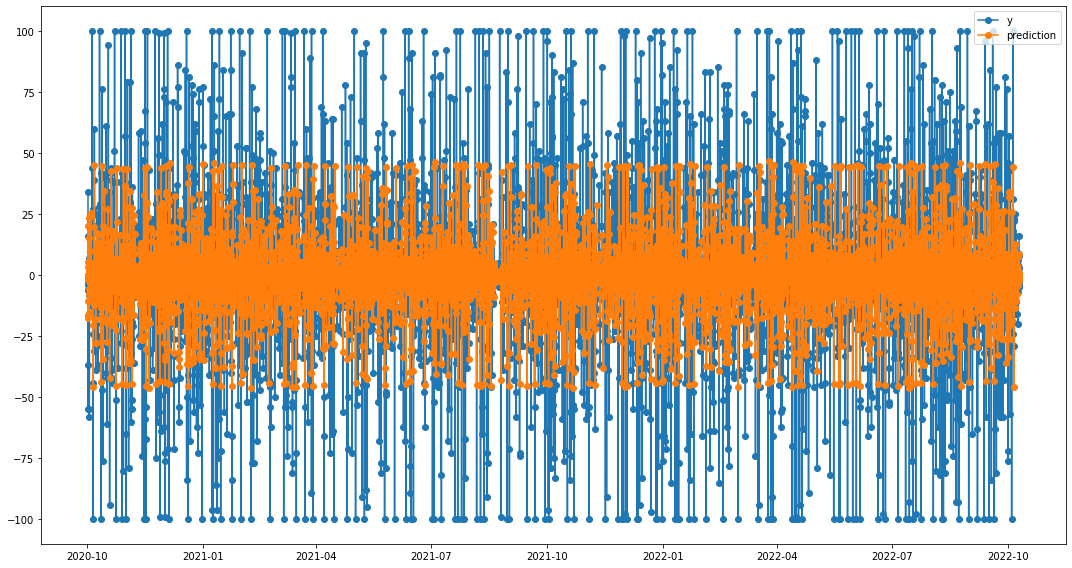

In [19]:
fig, ax = plt.subplots(figsize=(15, 8))
kws = dict(marker="o")
ax.plot(pd_pred.y, label="y", **kws)
ax.plot(pd_pred.prediction, label="prediction", **kws)
ax.legend()
fig.tight_layout()

## Classification

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics

#!pip install --upgrade pretty-confusion-matrix --user
from pretty_confusion_matrix import pp_matrix

In [22]:
def assign_class(value):
    for _range, _class in decision_boundaries.items():
        # for every pair that you see in table
        if _range[0] <= value < _range[1]:
            return _class

In [25]:
train_summary = pred_train.toPandas()
test_summary = pred_test.toPandas()

<AxesSubplot: xlabel='y', ylabel='Density'>

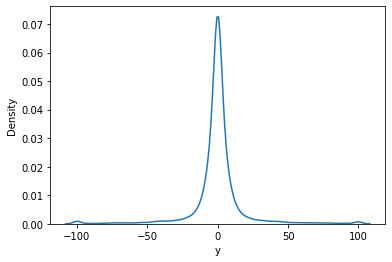

In [26]:
sns.kdeplot(train_summary.y)

<AxesSubplot: xlabel='y', ylabel='Density'>

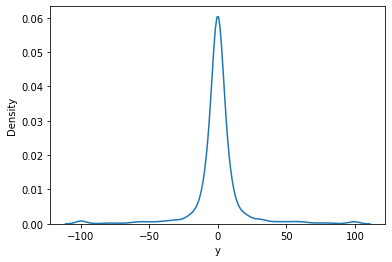

In [27]:
sns.kdeplot(test_summary.y)

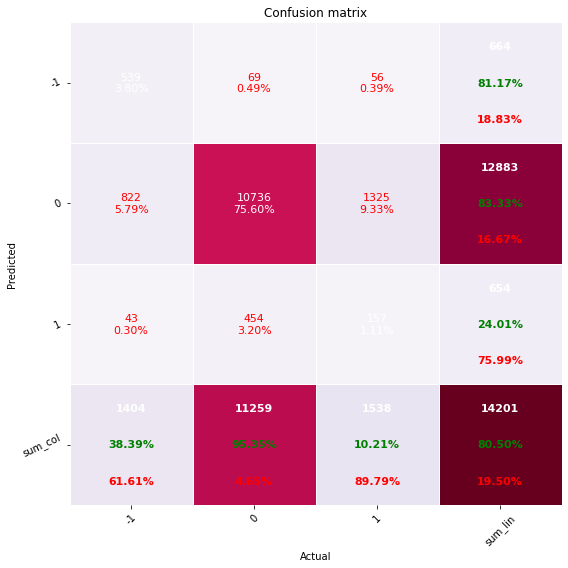

In [29]:
# changes to frame the regression problem as a classification problem & evaluation on train set
decision_boundaries = {
    (-np.inf, -train_summary.y.quantile(0.9)): -1,
    (-train_summary.y.quantile(0.9), train_summary.y.quantile(0.9)): 0,
    (train_summary.y.quantile(0.9), np.inf): 1,
}

train_summary["class"] = train_summary.y.apply(assign_class)
train_summary["pred_class"] = train_summary.prediction.apply(assign_class)

y_train_true = train_summary["class"]
y_train_pred = train_summary["pred_class"]

array = metrics.confusion_matrix(y_train_true, y_train_pred)
df_cm = pd.DataFrame(
    array,
    index=decision_boundaries.values(),
    columns=decision_boundaries.values(),
)
cmap = "PuRd"
pp_matrix(df_cm, cmap=cmap)

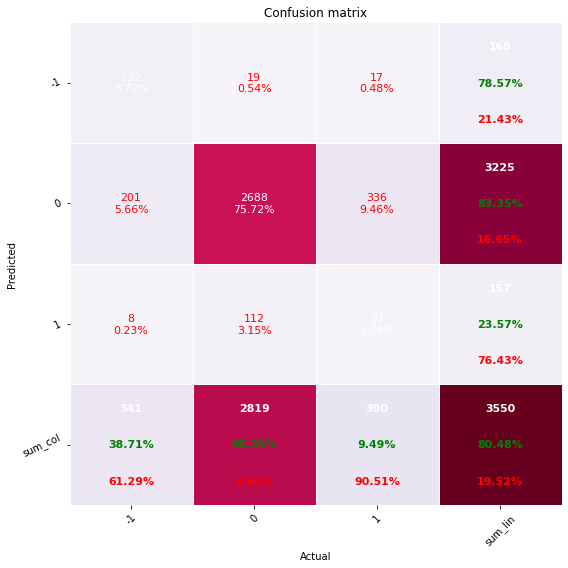

In [30]:
# changes to frame the regression problem as a classification problem & evaluation on test set
decision_boundaries = {
    (-np.inf, -test_summary.y.quantile(0.9)): -1,
    (-test_summary.y.quantile(0.9), test_summary.y.quantile(0.9)): 0,
    (test_summary.y.quantile(0.9), np.inf): 1
}

test_summary['class'] = test_summary.y.apply(assign_class)
test_summary['pred_class'] = test_summary.prediction.apply(assign_class)

y_test_true = test_summary['class']
y_test_pred = test_summary['pred_class']

array = metrics.confusion_matrix(y_test_true, y_test_pred)
df_cm = pd.DataFrame(array, index=decision_boundaries.values(), columns=decision_boundaries.values())
cmap = 'PuRd'
pp_matrix(df_cm, cmap=cmap)